In [120]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection done by eXtreme Gradient Boosting (XGBoost)


In [121]:
import os, sys
import copy as cp
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines_continous as p

s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))


import warnings
warnings.filterwarnings('ignore')


In [122]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss.xlsx")
df_candidates.tail(2)


,Target_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,contaminations_light,contaminations_heavy,shp_content_value_euro,elevation_m,shp_registered_capital_euro
395,0.0,4.0,70.0,0,1,NaN,1,0,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,1,NaN,130.0,NaN,1,17,2,3,1,3.0,3.0,1.0,5,1.0,2.0,1,0,NaN,1.83886,11047.7
396,0.0,3.0,100.0,0,1,NaN,1,0,1,0,0,0,0,0,0,1,5,5,5,5,5,5,4,NaN,0,5.0,33.0,1.0,1,11,2,3,1,3.0,4.0,NaN,5,NaN,3.0,1,0,NaN,1.87277,736.5


In [123]:
## delete features with more than 10% missing values

print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 
## --> kepp threshold by 15% less would delete important features e.g. content values, registerd capitaletc.

# drop warning time due to 77% nan
df_candidates = df_candidates.drop("warning_time_h", axis=1)

Percentage of missing valeus per feature
 warning_time_h                                 0.775819
elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.158690
shp_registered_capital_euro                    0.118388
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
hh_monthly_income_cat                          0.060453
shp_monetary_resources4prevention              0.045340
resilience_city_protection                     0.037783
Target_contentloss_euro                        0.037783
resilience_neighbor_management                 0.027708
inundation_duration_h                          0.022670
elevation_m                                    0.010076
b_area                                         0.005038
dtype: float64


## select only damage cases

In [124]:
targets = ["Target_contentloss_euro", "Target_businessreduction"]
target = targets[0]


In [125]:
print(f"Removing {df_candidates.loc[df_candidates[target]==0,:].shape[0]} zero loss records")
df_candidates = df_candidates.loc[df_candidates[target]!=0,:]

print(f"Keeping {df_candidates.shape} damage cases for model training and evaluation")

Removing 226 zero loss records
Keeping (171, 43) damage cases for model training and evaluation


### Target varibale distribution

count       156.000000
mean       2242.412179
std       18219.509814
min           7.400000
25%          39.700000
50%         137.950000
75%         382.700000
max      224190.400000
Name: Target_contentloss_euro, dtype: float64


<Figure size 2000x1000 with 0 Axes>

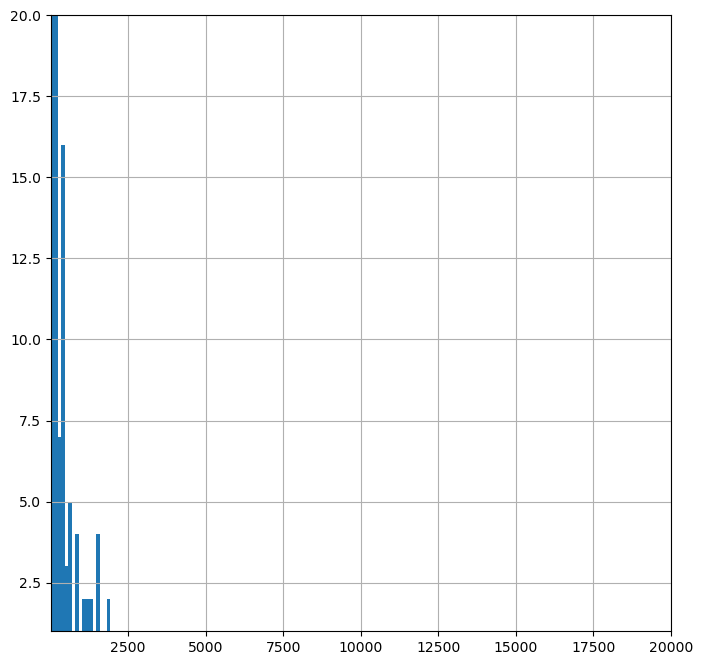

In [126]:
plt.figure(figsize=(8, 8))

print(df_candidates[target].describe())

closses = df_candidates[target] #df_candidates[target][df_candidates[target] != 0.0 ]
closses.hist(bins=2000, figsize=(8, 8))
plt.ylim(1, 20)
plt.xlim(1, 20000)
plt.show()

## Fit model 

In [202]:
learning_rate = [ 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5] # store outside, for plotting

param_grid = {'model__n_estimators': [ 50, 100, 200, 300, 500, 1000],
    #'model__n_estimators': [ 3, 5, 10, 20], # get only low train scores with this
              'model__max_depth': [1, 2, 3, 5, 7, 8, 10, 15],
              #'model__max_leaves': [0, 3, 5],
             # 'model__colsample_bytree': [ 0.3, 0.5, 0.7, 1.0 ], # Percentage of columns to be randomly samples for each tree
             # 'model__colsample_bynode': [ 0.3, 0.5, 0.7, 1.0], # nbr of feautres for each split point
              'model__eta': learning_rate,  # == eta
            #   'model__gamma': [0.2, 0.3, 0.5, 0.8, 1, 3] , # min_split_loss -  larger gamma is, the more conservative the algorithm is
              'model__subsample': [0.2, 0.5, 0.6, 0.8, 0.9],  # define subsample of train st prior to growing trees, prevent overfitting
             'model__reg_alpha': [0.5, 1.0, 2.0, 4.0, 5.0, 6.0 ],   # Lasso Regularization term on weights , higher values = more consrvative 
             'model__reg_lambda': [0.0, 0.1, 0.5, 1.0, 2.0, 3.0],  # Ridge Regularization term on weights ,  higher values = more consrvative
            #   'model__min_child_weight': [0, 1, 2, 3, 4,],
            #   "model__max_delta_step":  [0, 3, 5, 6, 7],           # for LogisticReg good to solve imbalance 
           # 'model__objective': [None, 'reg:absoluteerror'],#'multi:softprob,'reg:squarederror','reg:models_trained'],
           # 'model__tree_method': ["hist", "gpu_hist"],
            #   'model__booster': [None, "gblinear", "gbtree"]
            "model__validate_parameters":[True],
              }
# 'model__scale_pos_weight': [0.0, 0.3, 0.5, 0.7, 0.9, 1.0],  # only  for clasifcation: handle imbalance, ratio between negative and positive examples

# Objective candidate: multi:softmax
# Objective candidate: multi:softprob
# Objective candidate: reg:squarederror
# Objective candidate: reg:squaredlogerror
# Objective candidate: reg:logistic
## Objective candidate: reg:linear
# Objective candidate: reg:pseudohubererror
# Objective candidate: reg:gamma
# Objective candidate: reg:absoluteerror

## DOC: https://xgboost.readthedocs.io/en/stable/parameter.html


In [201]:
## iterate over both targets and store results 

fi_threshold = 0.000
eval_set_list = []

targets = ["Target_contentloss_euro"]# , "Target_businessreduction"]
#importances_threshold = {"target_contentloss_euro": 0.000, "Target_businessreduction": 0.000 }

plt.ioff()  # Prevent plt showing stuff

# def best_ntree_score(estimator, X, y):
#     """
#     This scorer uses the best_ntree_limit to return
#     the best AUC ROC score
#     """
#     try:
#         y_predict = estimator.predict_proba(X,
#                                             ntree_limit=estimator.best_ntree_limit)
#     except AttributeError:
#         y_predict = estimator.predict_proba(X)
#     return roc_auc_score(y, y_predict[:, 1])


for target in targets:


    ## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
    pipelines = ["pipe_xgb"]#, "pipe_ximput_xgb"]
        

    for pipe_name in pipelines:

        print( f"\nApply XGBoost on {target}, with pipeline {pipe_name}:")

        ## load sinlge pipeline
        pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
        
        
        df_candidates_t = df_candidates

        ## TEST run xgb with and without nan in X
        ## clean df from remaining records containg nan
        #df_candidates_t = df_candidates_t.dropna()
        #df_candidates_t = df_candidates_t[df_candidates_t[target]!=0.0]

        #print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
        print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
            { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")


        ## drop samples where target is nan
        print(f"Dropping {df_candidates_t[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
        df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]


        if pipe_name != "pipe_ximput_xgb":
            pass
            # ## drop instances where target is nan
            # print("Before dropping records with nan", df_candidates_t.shape)
            # df_candidates_t = df_candidates_t.dropna()
            # print("After dropping records with nan", df_candidates_t.shape)
        else:
            ##impute nans in X
            for c in df_candidates_t.drop(targets, axis=1).columns: 
                #df_candidates_t[f"{c}"].fillna(value=np.nanmedian(df_candidates_t[f"{c}"]), inplace=True)
                df_candidates_t[c].fillna(df_candidates_t[c].median(), inplace=True)
       
        # split into predictors and target variable
        X_unscaled = df_candidates_t.drop([target] + targets, axis=1)  # remove targets from X
        y = df_candidates_t[target]
        
        ## test train split
        X_train, X_test, y_train, y_test = train_test_split(
            X_unscaled, y, test_size=0.25, 
            random_state=seed, shuffle=True
        )
        ## save evaluation set for later usage in feature importance
        eval_set =  pd.concat([y_test, X_test], axis=1) #[(X_test, y_test)]
        eval_set_list.append({pipe_name : eval_set})
        
        print("Training set size", X_train.shape[0])
        print("Test set size", X_test.shape[0])

        ## normalize data 
        X_train, X_test = fs.normalize_X(X_train, X_test)

        ## Hyperparmaters and CV
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 
        #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)#, random_state=seed)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
        model_cv = RandomizedSearchCV(   #         #GridSearchCV(
            estimator=pipe, 
            #param_grid=param_grid,
            param_distributions=param_grid, 
            random_state=seed,
            cv=cv, 
            scoring= "neg_mean_absolute_error",
            #best_ntree_score(XGBRegressor, X_train, y_train) , #"neg_mean_absolute_error",   #
            refit=True,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
                            ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
                            ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
            verbose=False,
        )
        ## Fit best model on training set
        model_cv.fit(
            X_train, y_train,
            model__early_stopping_rounds=50,
            model__eval_metric="mae",
            model__eval_set=[(X_test, y_test)],
            model__verbose=False
            )
 
        print(f"Best hyperparams: {model_cv.best_params_}")
        # print("Train R^2 Score : %.1f" %model_cv.best_estimator_.score(X_train, y_train))
        #print("MAE of best model: %.1f" %model_cv.best_score_," on iteration ", model_cv.best_estimator_.best_iteration)  

        # fit model again with best hyperparams
        print("Create new XGBoost model based on best hyperparameters")
        model = model_cv.best_estimator_
         
        ## store best trained model for evaluation
        filename = f'./models_trained/xgboost_{target}_{pipe_name}.sav'
        #pickle.dump(model_cv.best_estimator_, open(filename, 'wb'))
        pickle.dump(model, open(filename, 'wb'))

        ## Evaluate model
        # print(f"Training set score (R^2): {round(model.score(X_train, y_train), 2)}")  # how well did the model on the training set
        # print(f"Test set score (R^2): {model_cv.score(X_test, y_test)}")   # .. compared to the unseen test set for overfitting - acutal not needed
        # r2 = variance explained by model / total variance --> higher r2= better fitted model

        ## get signifcant features based on absolute coeff values
        print("\nSelect features based on permutation feature importance")

        # ## select significant features byPermuation feature importance
        importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

        df_importance = pd.DataFrame(
            {"importances" : importances[0]},
            index=X_train.columns.to_list(),
            ) 
        df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
        print("Most important features:", df_importance.iloc[:5].index.to_list())
        df_importance = df_importance.loc[df_importance.importances >= fi_threshold, : ]
        #df_importance.head(5)
        # ## write selected predictors and response to disk
        fs.save_selected_features(
            X_train, 
            pd.DataFrame(y_train, columns=[target]), 
            df_importance.T.columns, 
            filename=f"../../../input_survey_data/fs_xgboost_{target.split('_')[1]}_{pipe_name}_cntn.xlsx"
        )

        ## Evaluate
        ## print evaluation report + check for overfitting 
        print("\nTraining set")
        y_pred_train = model.predict(X_train)
        #y_pred_train = model_cv.best_estimator_.predict(X_train)
        e.evaluation_report(y_train, y_pred_train,
                            X_unscaled.shape[1], 
                            filepath=f"./models_evaluation/elastic_net/eval_train_{target.split('_')[1]}_{pipe_name}.csv")

        print("\nTesting set")
        #y_pred = model_cv.best_estimator_.predict(X_test)
        y_pred = model.predict(X_test)
        e.evaluation_report(y_test, y_pred, 
                            X_unscaled.shape[1], 
                            filepath=f"./models_evaluation/elastic_net/eval_test_{target.split('_')[1]}_{pipe_name}.csv")



Apply XGBoost on Target_contentloss_euro, with pipeline pipe_xgb:
Uses  171  records, from those have  {0}  records zero contentloss
Dropping 15 records from entire dataset due that these values are nan in target variable
Training set size 117
Test set size 39
Best hyperparams: {'model__validate_parameters': True, 'model__subsample': 0.9, 'model__reg_lambda': 2.0, 'model__reg_alpha': 4.0, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__eta': 0.4}
Create new XGBoost model based on best hyperparameters

Select features based on permutation feature importance
Most important features: ['shp_content_value_euro', 'shp_employees', 'resilience_left_alone', 'elevation_building_impl', 'b_area']
total features: 42
selected features: 23
dropped features: 19
selected features: 
['shp_content_value_euro', 'shp_employees', 'resilience_left_alone', 'elevation_building_impl', 'b_area', 'elevation_m', 'water_barriers_impl', 'emergency_measures.3', 'electricity_higher_impl', 'resilience_neigh

In [203]:
model_cv.best_params_

# 75 % in train mit 300 trress, subsam0.8, maxdep=3, aber bad teest R2


{'model__validate_parameters': True,
 'model__subsample': 0.9,
 'model__reg_lambda': 2.0,
 'model__reg_alpha': 4.0,
 'model__n_estimators': 200,
 'model__max_depth': 3,
 'model__eta': 0.4}

In [ ]:
## Plot learning rate see if    
means = model_cv.cv_results_['mean_test_score']
stds = model_cv.cv_results_['std_test_score']
params = model_cv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # plot
    plt.errorbar(learning_rate, means, yerr=stds)
    plt.title("XGBoost learning_rate vs Log Loss")
    plt.xlabel('learning_rate')
    plt.ylabel('Log Loss')
    plt.savefig('learning_rate.png')

In [179]:
#model_cv.cv_results_.get("rank_test_score")
model_cv.cv_results_.get("mean_test_score")

array([ -4130.67856349,  -2910.09700882, -14928.96795907,  -5097.28830228,
        -3342.94989408,  -3859.81378931,  -4047.15437388,  -3714.01854439,
        -4462.63498374,  -3566.7385018 ])

In [187]:
# results = model_eval.evals_result()

# plt.figure(figsize=(10,7))
# plt.plot(results["validation_0"]["rmse"], label="Training loss")
# plt.plot(results["validation_1"]["rmse"], label="Validation loss")
# plt.axvline(21, color="gray", label="Optimal tree number")
# plt.xlabel("Number of trees")
# plt.ylabel("Loss")
# plt.legend()

AttributeError: 'Pipeline' object has no attribute 'evals_result'

In [78]:
model =   XGBRegressor(n_estimators=30)

model.fit(X_train, y_train)

model.best_ntree_limit

30

In [ ]:
model.get_booster


In [ ]:
# print('running cross validation, with preprocessing function')
# # define the preprocessing function
# # used to return the preprocessed training, test data, and parameter
# # we can use this to do weight rescale, etc.
# # as a example, we try to set scale_pos_weight
# def fpreproc(dtrain, dtest, param):
#     label = dtrain.get_label()
#     ratio = float(np.sum(label == 0)) / np.sum(label == 1)
#     param['scale_pos_weight'] = ratio  #  ratio of number of negative class to the positive class
#     return (dtrain, dtest, param)

# # do cross validation, for each fold
# # the dtrain, dtest, param will be passed into fpreproc
# # then the return value of fpreproc will be used to generate
# # results of that fold
# xgb.cv(param, dtrain, num_round, nfold=5,
#        metrics={'auc'}, seed=0, fpreproc=fpreproc)

In [180]:
#plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')
#sns_plot.figure.savefig("output.png")
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.7651809450669104
-0.05914785305530312


## Reload model

In [186]:
## reload models

target = targets[0]
print(target)

model_eval = pickle.load(open(f"./models_trained/xgboost_{target}_{pipe_name}.sav", 'rb'))
#model_eval.get_params()
#dir(model_eval)#.feature_importances_[model_eval.feature_importances_>0.015].shape

Target_contentloss_euro


### Feature importance
Have the same feature importance method across all applied ML models


In [ ]:
# ## Permuation feature importance
# result = e.permutation_feature_importance(model_eval, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : result[0],
#      }) 
# df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
# df_importance.head(5)

In [ ]:
# plot feature importance

# f.plot_feature_importance(df_importance.importances, n=10, figure_size=(20, 15), target=target)

fig, ax = plt.subplots(figsize=(12,10))

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances >= 0.001, : ] 
#sorted_idx = model_eval.feature_importances_.argsort()
#plt.barh(df_importance.name[-5:], df_importance.importances[-5:])
plt.bar(df_importance.name, df_importance.importances)
#plt.bar(X_train.columns[sorted_idx[:15]], model_eval.feature_importances_[sorted_idx[:15]])
plt.xticks(
   # ticks = range(len(X_train.columns[sorted_idx[:15]])),
   # labels =X_train.columns[sorted_idx[:15],],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

##### Hierarchical clustering on Spearman rank correlation

Select only feautres with low collienarity to solve disadvantage of perumation feature importance.
Randomizing one feature would lead to only small importance score - the model performance wouldnt be move influenced - due that the information is included in other correlated features. Removing one feature keeps the similar inforamtion in the other feautres unchanged and the model learns from the correlated feature. Therefore apply hierachical clustering to select less correlated features

See also:
- Brill 2020 (dissertation)
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html # code example

In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(15, 10))
# plt.title("Customers Dendrogram")

# # Selecting Annual Income and Spending Scores by index
# selected_data = X_train.dropna()
# selected_data = selected_data.T # only possible with out nan
# clusters = shc.linkage(selected_data, 
#             method='ward', optimal_ordering=False,
#             metric="euclidean")
# shc.dendrogram(Z=clusters, 
#                #p=20, # p -> value for truncation mode
#                orientation="right",
#                labels=X_train.columns
#                ) 
# plt.show()

# ## TODO adapt with spearman rank order



In [ ]:

# from scipy.stats import spearmanr
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import ward, dendrogram

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X_unscaled_no_nan).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = ward(distance_matrix, checks=False )
# dendro = dendrogram(
#     dist_linkage, labels=X_unscaled_no_nan.columns.tolist(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()


In [ ]:
cluster_ids = shc.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]


In [ ]:
## permutation based FI (build in func from skilearn)

# perm_importance = permutation_importance(xgb, X_test, y_test)
# The visualization of the importance:

# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")